# Getting Started with the Assistants API

During the public preview, the Assistants API is not available everywhere. Check https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models#assistants-preview. I will use Sweden Central.

The API version to use in Azure is 2024-02-15-preview

Let's start creating an Azure OpenAI client...


In [2]:
import os
from dotenv import load_dotenv
from openai import AzureOpenAI

# Load environment variables from .env file
# AZURE_OPENAI_API_KEY
# AZURE_OPENAI_ENDPOINT
# AZURE_OPENAI_API_VERSION
load_dotenv()

# Create Azure OpenAI client
client = AzureOpenAI(
    api_key=os.getenv('AZURE_OPENAI_API_KEY'),
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
    api_version=os.getenv('AZURE_OPENAI_API_VERSION')
)


## Creating the assistant

In [3]:
assistant = client.beta.assistants.create(
    name="Math Tutor",
    instructions="""You are a math tutor that helps users solve math problems. 
    You have access to a sandboxed environment for writing and testing code. 
    Explain to the user why you used the code and how it works
    """,
    tools=[{"type": "code_interpreter"}],
    model="gpt-4-8k" # ensure you have a deployment in the region you are using
)

# display information about the assistant
print(assistant.model_dump_json(indent=2))


{
  "id": "asst_RfNCuH5lPP2J2avokY426ojm",
  "created_at": 1708975265,
  "description": null,
  "file_ids": [],
  "instructions": "You are a math tutor that helps users solve math problems. \n    You have access to a sandboxed environment for writing and testing code. \n    Explain to the user why you used the code and how it works\n    ",
  "metadata": {},
  "model": "gpt-4-8k",
  "name": "Math Tutor",
  "object": "assistant",
  "tools": [
    {
      "type": "code_interpreter"
    }
  ]
}


Above, you can see an assistant has a unique ID. For some reason, you don't see this ID in the Azure OpenAI Playground. With OpenAI, the assistants you create are shown in their portal.

## Creating a thread

Now we can create a thread. A thread is **not linked** to the assistant at creation time

In [4]:
# Create a thread
thread = client.beta.threads.create()

# Threads have an id as well
print("Thread id: ", thread.id)

Thread id:  thread_8QN91zMiuoQc2kprM5RAgJOA


## Adding a user question

Now we can add a user question to the thread via a **message**. The message is put on the thread via its ID.

After adding the message, we get the messages from the tread and dump them. Every message has an ID and content. The type of content we add is just text and comes from a user (role=user).

In [5]:
# Add a user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Solve the equation y = x^2 + 3 for x = 3 and plot the function graph."
)

# Show the messages
thread_messages = client.beta.threads.messages.list(thread.id)
print(thread_messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_CDnCXKwH0a4kM7pUx0c1DTc1",
      "assistant_id": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "Solve the equation y = x^2 + 3 for x = 3 and plot the function graph."
          },
          "type": "text"
        }
      ],
      "created_at": 1708975280,
      "file_ids": [],
      "metadata": {},
      "object": "thread.message",
      "role": "user",
      "run_id": null,
      "thread_id": "thread_8QN91zMiuoQc2kprM5RAgJOA"
    }
  ],
  "object": "list",
  "first_id": "msg_CDnCXKwH0a4kM7pUx0c1DTc1",
  "last_id": "msg_CDnCXKwH0a4kM7pUx0c1DTc1",
  "has_more": false
}


## Running a thread

Adding a message to a thread does not do much. To get a response from the assistant's model, we need to run the thread.

When you run the thread, you can provide extra instructions via the `instructions` parameter. We do not do that below.

A thread is run asychronously. We need to check the run status to see if it is done. After you run the cell below, keep running the cell under it until the status is `completed`. When it is not completed, the status is `in_progress`.

Other statuses: cancelled, expired, failed

In [6]:
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

In [9]:
# run this until the run is completed
# it can take a while before the run is completed
# POZOR: in a real application, create a loop that waits for the run to complete !!!
run = client.beta.threads.runs.retrieve(
  thread_id=thread.id,
  run_id=run.id
)

status = run.status
print(status)

completed


## Result of the run

To see what happened, we have to check the messages of the thread. The user message will be at the bottom. There should be a message with role=assistant. This is the response from the assistant's model. The message has a `content` field with the response. There can be multiple types of responses, for instance text and image.

In [10]:
# dump the messages on the thread again
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

print(messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_XFeAzZYnPVaQAMs2mJr7sfwI",
      "assistant_id": "asst_RfNCuH5lPP2J2avokY426ojm",
      "content": [
        {
          "image_file": {
            "file_id": "assistant-TPSg9L3q0iyYMmanjQhAzzNJ"
          },
          "type": "image_file"
        },
        {
          "text": {
            "annotations": [],
            "value": "The value of y for x=3 in the equation y = x^2 + 3 is 12. This point is marked in red on the graph. \n\nThe graph displays the function y = x^2 + 3. You can see that the function describes a parabola that opens upward, with a minimum point at y=3 when x=0. This is typical for functions of the form y = x^2 + constant, and in this case, the constant is 3. \n\nThis graph gives a visual representation of all the possible (x, y) pairs that satisfy the equation. For any given value of x, you can find the corresponding value of y by locating the point on the graph vertically above or below x on the x-axis. Similarly, for any gi

## Showing the response

We can show all messages in the array in reverse order to start from the beginning. Depending on the content (text, image) we can do something with it.

For now just print the text or file_id if there is one

In [11]:
import json

messages_json = json.loads(messages.model_dump_json())

for item in reversed(messages_json['data']):
    # Check the content array
    for content in reversed(item['content']):
        # If there is text in the content array, print it
        if 'text' in content:
            print(content['text']['value'], "\n")
        # If there is an image_file in the content, print the file_id
        if 'image_file' in content:
            print("Image ID:" , content['image_file']['file_id'], "\n")

Solve the equation y = x^2 + 3 for x = 3 and plot the function graph. 

Sure, to solve the equation for a specific x value we simply substitute x with the given value and perform the calculation. 

In this case, we would substitute x with 3 in the equation "y = x^2 + 3".

For the second part of your request, to plot this function we need to create a range of x values and then use the equation to calculate the associated y values. We can then use these values to create a graph.

Let me do that for you. 

The value of y for x=3 in the equation y = x^2 + 3 is 12. This point is marked in red on the graph. 

The graph displays the function y = x^2 + 3. You can see that the function describes a parabola that opens upward, with a minimum point at y=3 when x=0. This is typical for functions of the form y = x^2 + constant, and in this case, the constant is 3. 

This graph gives a visual representation of all the possible (x, y) pairs that satisfy the equation. For any given value of x, you can 

## Retrieving the image file

Same code as above but show the image with PIL and IPython.display

Solve the equation y = x^2 + 3 for x = 3 and plot the function graph. 

Sure, to solve the equation for a specific x value we simply substitute x with the given value and perform the calculation. 

In this case, we would substitute x with 3 in the equation "y = x^2 + 3".

For the second part of your request, to plot this function we need to create a range of x values and then use the equation to calculate the associated y values. We can then use these values to create a graph.

Let me do that for you. 

The value of y for x=3 in the equation y = x^2 + 3 is 12. This point is marked in red on the graph. 

The graph displays the function y = x^2 + 3. You can see that the function describes a parabola that opens upward, with a minimum point at y=3 when x=0. This is typical for functions of the form y = x^2 + constant, and in this case, the constant is 3. 

This graph gives a visual representation of all the possible (x, y) pairs that satisfy the equation. For any given value of x, you can 

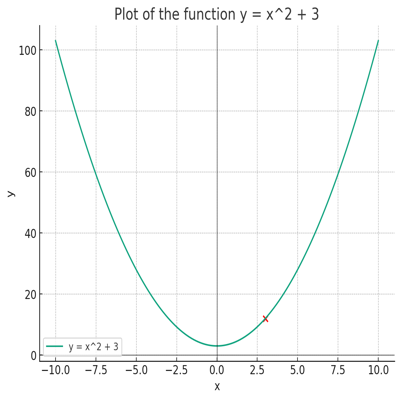

In [12]:
from PIL import Image
from IPython.display import display

for item in reversed(messages_json['data']):
    # Check the content array
    for content in reversed(item['content']):
        # If there is text in the content array, print it
        if 'text' in content:
            print(content['text']['value'], "\n")
        # If there is an image_file in the content, print the file_id
        if 'image_file' in content:
            file_id = content['image_file']['file_id']
            file_content = client.files.content(file_id)
            # use PIL with the file_content
            img = Image.open(file_content)
            img = img.resize((400, 400))
            display(img)
            
            


## Ask another question

We can add another user message to the thread and run it again. But now, we will wait for the response and display it right away.

We will use Markdown to display the assistant's response.

The new_run function is a helper function to add a question 

Status: completed


Solve the equation y = x^2 + 3 for x = 3 and plot the function graph.

Sure, to solve the equation for a specific x value we simply substitute x with the given value and perform the calculation. 

In this case, we would substitute x with 3 in the equation "y = x^2 + 3".

For the second part of your request, to plot this function we need to create a range of x values and then use the equation to calculate the associated y values. We can then use these values to create a graph.

Let me do that for you.

The value of y for x=3 in the equation y = x^2 + 3 is 12. This point is marked in red on the graph. 

The graph displays the function y = x^2 + 3. You can see that the function describes a parabola that opens upward, with a minimum point at y=3 when x=0. This is typical for functions of the form y = x^2 + constant, and in this case, the constant is 3. 

This graph gives a visual representation of all the possible (x, y) pairs that satisfy the equation. For any given value of x, you can find the corresponding value of y by locating the point on the graph vertically above or below x on the x-axis. Similarly, for any given value of y, you can find the corresponding x values by locating the points on the graph that are horizontally left or right from y on the y-axis. 

For example, in the case where x=3, you can see from the plot that y=12, which is the same result we got by calculation.

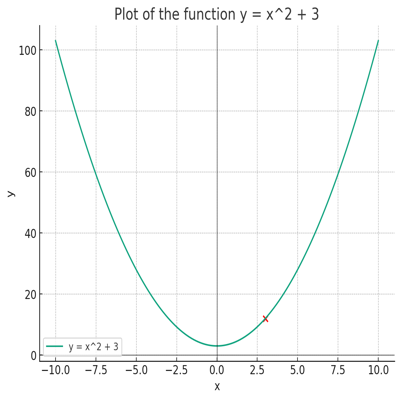

Is this a concave function?

Yes, this is a concave function, specifically a concave up function. 

In mathematics, a function is said to be concave up (also known as convex) on an interval if the function's graph lies below its tangent lines on that interval. In simpler terms, if a function opens upwards like a cup, it's concave up.

For a function f(x), if the second derivative of the function, denoted as f''(x), is positive, the function is concave up. For the given function y = x^2 + 3:

The first derivative f'(x) = 2x.

The second derivative f''(x) = 2.

Since the second derivative is positive (2), this confirms that the function is concave up. 

The second derivative test is a useful tool for identifying the concavity of a function. Concavity, along with the function's first derivative, helps in determining the local minima and maxima, which is particularly useful in optimization problems.

In [13]:
from IPython.display import clear_output, display, Markdown
import time

def new_run(question, thread_id):

    # add new message to the thread
    message = client.beta.threads.messages.create(
        thread_id=thread_id,
        role="user",
        content=question
    )

    # run the tread again
    run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id
    )

    status = run.status

    while status not in ["completed", "cancelled", "expired", "failed"]:
        time.sleep(2)
        run = client.beta.threads.runs.retrieve(thread_id=thread.id,run_id=run.id)
        status = run.status
        print(f'Status: {status}')
        clear_output(wait=True)

    print(f'Status: {status}')

    messages = client.beta.threads.messages.list(
        thread_id=thread.id
    )

    messages_json = json.loads(messages.model_dump_json())

    for item in reversed(messages_json['data']):
        # Check the content array
        for content in reversed(item['content']):
            # If there is text in the content array, print it as Markdown
            if 'text' in content:
                display(Markdown(content['text']['value']))
            # If there is an image_file in the content, print the file_id
            if 'image_file' in content:
                file_id = content['image_file']['file_id']
                file_content = client.files.content(file_id)
                # use PIL with the file_content
                img = Image.open(file_content)
                img = img.resize((400, 400))
                display(img)

new_run("Is this a concave function?", thread.id)

In [14]:
# create a new thread and run
thread = client.beta.threads.create()
new_run("If a woman has two kids of 5 and 7 and she is 33, how many years does it take for the age of the two children to be exactly half her age", thread.id)

Status: completed


If a woman has two kids of 5 and 7 and she is 33, how many years does it take for the age of the two children to be exactly half her age

Let's establish our variables:

- The initial age of the woman is 33 years, represented as W.
- The initial age of the first child is 5 years, represented as C1.
- The initial age of the second child is 7 years, represented as C2.
- The amount of years until the combined age of the children is exactly half the woman's age is what we are trying to find, represented as Y.

With these variables in hand, we can set up and solve a simple equation. For the combined age of the children (C1 + C2 + Y) to be exactly half the woman's age (W + Y), they will have to satisfy the following equation:

C1 + C2 + Y = 0.5 * (W + Y)

We can solve this equation for Y to find the answer to the problem.

We'll now use Python, a versatile programming language, to solve this equation. Python has built-in capabilities to handle such math problems swiftly. We'll plug the known values (33, 5, 7) into the equation and solve for Y.

I apologize for the error, it seems there was a problem with the execution. 
Let's try to solve the equation again using plain Python arithmetic operations instead of the symbolic approach. 

We can rearrange the original equation and simplify it into a simpler form where we calculate the years by following these steps: 

1. Multiply both sides of the equation by 2 to remove the fractional component: 2 * (C1 + C2 + Y) = W + Y

2. Rearrange the equation to isolate Y (the unknown): Y = 2*(C1 + C2) - W

3. Now we can use this new and simpler equation to calculate Y. Let's do that.

I apologize, there seemed to have been an error. I forgot to re-define the variables. Allow me to correct this error. These variables represent the ages of each individual:

- W for the woman's age, which is 33 years.
- C1 for the first child's age, which is 5 years.
- C2 for the second child's age, which is 7 years. 

Let me fix this.

The calculation yielded a negative result (-9 years), which doesn't make sense in our context as age can't be negative. There seems to be an error in my calculation.

I apologize for the confusion - the equation should have been rearranged to isolate Y (the unknown variable that represents years) differently:

Y = 2 * (C1 + C2 + Y) - W

I will correct this and solve again.

I apologize for the error, it seems there was a problem with the execution. Let's try a different approach to solve this problem. 

The condition we need to satisfy is that the sum of the ages of the two kids must be half the woman's age after Y years. This can be represented by the equation:
(C1 + Y) + (C2 + Y) = 0.5 * (W + 2*Y)

We can start at Y = 0 and increment Y by 1 each time until the equation holds true. This is the brute force method and though not the most efficient, works with simple problems like this one. Let's calculate the value for Y using this method.

Apologies for the inconvenience. While my last method should normally work, it seems there's a technical issue preventing the operation. However, I'll try to solve this problem using a different approach by algebraically solving the equation.

By referring to the initial equation (C1 + C2 + Y = 0.5 * (W + Y)),
Let's isolate Y on one side of the equation:

Y = 2(C1 + C2) - W

If this gives a negative value, it means that the children's combined age has already surpassed half of the woman's age and she will have to "wait" for the children's combined age to catch up to half of her own age. So if the age is negative we calculate it by:

Y = (W - 2*(C1 + C2)) / 1.5

Let's do the calculation again.

I apologize for the inconvenience, it seems we're encountering some technical difficulties in running the Python code to solve this problem.

However, we can still work through the problem manually.

Let the total years needed be represented by 'Y'. After Y years, the woman will be 33 + Y years old, and each child will be respectively 5 + Y and 7 + Y years old.

We need to find 'Y' such that (5 + Y) + (7 + Y) equals half of (33 + Y).

This simplifies to (12 + 2Y = half*(33 + Y))

Removing the fraction will give 24 + 4Y = 33 + Y.

Solving for Y will result in Y = 9 years. 

So, it will take 9 years for the ages of the two children combined to be half the woman's age.